In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pickle
import scanpy.api as sc
import scipy
import seaborn as sns
from sklearn import decomposition
import time
import umap

datadir = '.'
outdir = '.'
figir = '.'

sc.logging.print_version_and_date()
sc.settings.verbosity = 3

/Users/david.fischer/miniconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


Running Scanpy 1.4.4.post1, on 2019-12-04 11:01.


In [2]:
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

This notebook contains an overview of the IEDB dataset.

This notebook creates the panels:
    - Fig. 4c

# Read data

Read observed TCRs:

In [3]:
iedb = pandas.read_csv(datadir+"tcell_receptor_table_export_1558607498.csv").fillna(value="None")
iedb_trb = iedb["Chain 2 CDR3 Curated"].values
iedb_antigen = iedb["Description"].values

/Users/david.fischer/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,12,15,16,17,19,20,21,22,23,24,29,30,35,36,50,51,53,58,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Take out None observations:

In [4]:
idx_to_keep = np.where([x != "None" and y != "None" for x, y in zip(iedb_trb, iedb_antigen)])[0]
iedb_trb = iedb_trb[idx_to_keep]
iedb_antigen = iedb_antigen[idx_to_keep]

In [5]:
print("Number of TRBs in data base: %i" % len(iedb_trb))

Number of TRBs in data base: 13478


# Assign TRBs to clonotypes

## Explore heterogeneity

In [6]:
def format_one_hot(
        x: list
) -> np.ndarray:
    """
    :param x: Input as list (length observations) of lists with strings of amino acid code of each chain.
    :return: 3D tensor [observations, amino acid position, amino acid embedding]
        One-hot encoded input.
    """
    aa_list = [
        'C', 'D', 'S', 'Q', 'K',
        'I', 'P', 'T', 'F', 'N',
        'G', 'H', 'L', 'R', 'W',
        'A', 'V', 'E', 'Y', 'M',
        '_'
    ]
    idx_list = np.arange(0, len(aa_list))
    dict_aa = dict(zip(aa_list, idx_list))
    dim_aa = len(dict_aa)
    
    # Remove sequences that contain amino acids that are not in list.
    keys_not_accounted_for = []
    x_clean = []
    for xx in x:
        if np.any([aa not in aa_list for aa in xx]):
            keys_not_accounted_for.extend([aa for aa in xx if aa not in aa_list])
        else:
            x_clean.append(xx)
    print(np.unique(np.array(keys_not_accounted_for)))
    
    dim_obs = len(x_clean)
    dim_pos = np.max([len(xi) for xi in x_clean])
    x_onehot = np.zeros([dim_obs, dim_pos, dim_aa])  # Second last dimension to use conv2d
    for i, xi in enumerate(x_clean):
        # Strip of empty space.
        xi = "".join(xi.split(" "))
        # Write missing string if chain not found.
        for k, aa in enumerate(xi):
            x_onehot[i, k, dict_aa[aa]] = 1
        # Fill remaining positions as None.
        for k in np.arange(len(xi), dim_pos):
            x_onehot[i, k, dict_aa['_']] = 1

    return x_onehot, x_clean, keys_not_accounted_for

Compute amino-acid embedding:

In [7]:
iedb_trb_oh, iedb_trb_clean, keys_not_accounted_for = format_one_hot(iedb_trb)

[' ' '#' '*' '1' '7' 'B' 'O' 'X' 'l']


In [8]:
print("%i out of %i TRB observations retained." % (iedb_trb_oh.shape[0], len(iedb_trb)))

13336 out of 13478 TRB observations retained.


Compute all-to-all manhatten distance matrix:

In [9]:
iedb_trb_oh_dist = (iedb_trb_oh-0.5)*2  # -1, 1 encoding
trb_dist = (iedb_trb_oh.shape[1]*iedb_trb_oh.shape[2] - np.matmul(
    np.reshape(iedb_trb_oh_dist, newshape=[iedb_trb_oh_dist.shape[0], -1]),
    np.reshape(iedb_trb_oh_dist, newshape=[iedb_trb_oh_dist.shape[0], -1]).T,
))/(2*2)
trb_dist[(np.arange(0, trb_dist.shape[0]), np.arange(0, trb_dist.shape[0]))] = np.nan

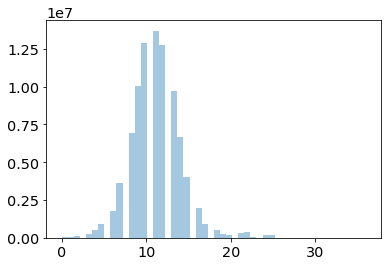

In [10]:
sns.distplot(
    trb_dist[np.triu_indices(trb_dist.shape[0], k=1)], 
    kde=False
)

Look at distance to closest neighbours:

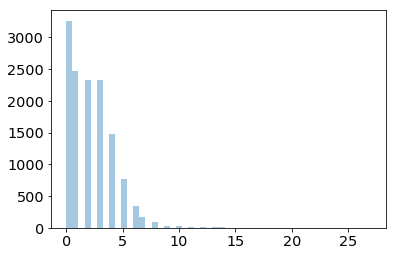

In [11]:
sns_data_nn = pandas.DataFrame({"neighbour0": np.nanmin(trb_dist, axis=1)})
sns.distplot(a=sns_data_nn["neighbour0"].values, kde=False)

In [12]:
sns_data_nn["neighbour0"].value_counts()

0.0     3261
1.0     2467
2.0     2329
3.0     2325
4.0     1480
5.0      762
6.0      347
7.0      173
8.0       89
9.0       35
10.0      27
11.0      12
13.0      10
12.0       7
14.0       6
16.0       3
15.0       2
27.0       1
Name: neighbour0, dtype: int64

### Distance metric validation

Look at an example case for validation of the steps above:

In [13]:
d = 1
idx_sample = np.concatenate(np.expand_dims(np.where(trb_dist == d), axis=0), axis=0)
print(iedb_trb_clean[idx_sample[0, 0]])
print(iedb_trb_clean[idx_sample[1, 0]])

CASRPGLMSAQPEQYF
CASRPGLMSARPEQYF


In [14]:
d = 3
idx_sample = np.concatenate(np.expand_dims(np.where(trb_dist == d), axis=0), axis=0)
print(iedb_trb_clean[idx_sample[0, 0]])
print(iedb_trb_clean[idx_sample[1, 0]])

CASRPGLAGGRPEQYF
CASRPGLMSARPEQYF


## Define clonotypes

Define clonotypes based on perfect sequence match.

In [15]:
clonotypes = np.zeros([trb_dist.shape[0]], int)
clonotype_counter = 0
for i in range(trb_dist.shape[0]):
    matches = np.where(trb_dist[i, :i] == 0)[0]
    if len(matches) > 0:
        clonotypes[i] = clonotypes[matches[0]]
    else:
        clonotypes[i] = clonotype_counter
        clonotype_counter = clonotype_counter + 1

### Explore size of clonotypes

Compute frequency of each clonotype:

In [16]:
clonotype_freq = pandas.DataFrame({"x": clonotypes})["x"].value_counts().values

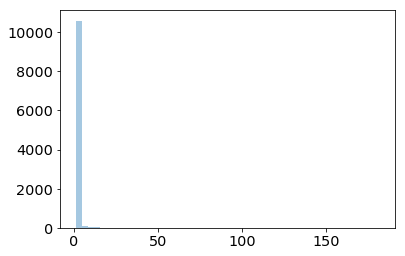

In [17]:
sns.distplot(a=clonotype_freq, kde=False)

Compute the frequency table of clonotype frequencies (information corresponding to the histogram above):

In [18]:
pandas.DataFrame({"x": clonotype_freq})["x"].value_counts().sort_index()

1      10075
2        353
3         91
4         67
5         26
6         22
7         24
8          6
9          6
10         7
11         4
12         1
13         3
14         8
15         4
16         1
17         4
18         3
19         2
20         1
21         2
22         5
28         1
36         1
40         1
42         1
51         1
53         1
59         1
60         1
112        1
134        1
182        1
Name: x, dtype: int64

In [19]:
print("total number of clonotypes: %i" % len(np.unique(clonotypes)))

total number of clonotypes: 10726


### Data set size if clonotypes are downsampled

In [20]:
def downsample_clono(assignments, max_per_clono):
    clonotypes = np.unique(assignments)
    n_cells = assignments.shape[0]
    idx_to_keep = np.concatenate([np.random.choice(
        a=np.arange(0, n_cells)[assignments == x],
        size=np.min([max_per_clono, np.sum(assignments == x)]),
        replace=False
    ) for x in np.unique(assignments)], axis=0)
    print("data set size downsampled to 10 cells per clonotypes reduces from %i to %i" % (len(assignments), len(idx_to_keep)))
    return len(assignments), len(idx_to_keep)

In [21]:
_ = downsample_clono(assignments=clonotypes, max_per_clono=10)

data set size downsampled to 10 cells per clonotypes reduces from 13336 to 12414


# Explore antigen heterogeneity

Number of unique antigens:

In [29]:
print(len(np.unique(iedb_antigen)))

71


In [22]:
antigen_freq = pandas.Series(iedb_antigen).value_counts().values
tcr_by_antigen_freq = pandas.DataFrame({"antigen": iedb_antigen, "tcr": iedb_trb}).groupby("antigen")["tcr"].nunique().values

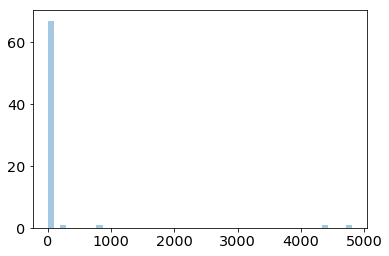

In [23]:
sns.distplot(a=tcr_by_antigen_freq, kde=False)

In [24]:
pandas.Series(tcr_by_antigen_freq).value_counts().sort_index()

1       34
2        9
3        2
4        5
5        3
6        1
10       2
11       1
12       1
19       2
23       1
51       1
56       1
61       1
84       1
89       1
96       1
261      1
850      1
4366     1
4812     1
dtype: int64

In [25]:
tcr_by_antigen_freq_table = pandas.DataFrame({"antigen": iedb_antigen, "tcr": iedb_trb}).groupby("antigen")["tcr"].nunique()
print([x for x in tcr_by_antigen_freq_table[tcr_by_antigen_freq_table > 20].index])

['AMFWSVPTV', 'CINGVCWTV', 'ELAGIGILTV', 'FLYNLLTRV', 'GILGFVFTL', 'GLCTLVAML', 'KLSALGINAV', 'LLWNGPMAV', 'NLVPMVATV', 'VLFGLGFAI', 'YVLDHLIVV']


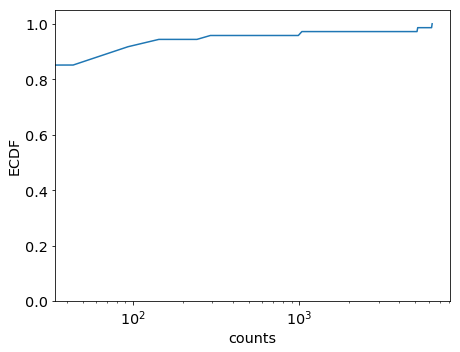

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 5))
sns.distplot(
    a=antigen_freq,
    hist=False, kde=True, kde_kws=dict(cumulative=True),
    ax=axs
)
axs.set_xscale('log')
axs.set_xlabel('counts')
axs.set_ylabel('ECDF')
fig.tight_layout() 
plt.savefig(figir+"supp_4_b.pdf")
plt.show()